## Dependencies

In [1]:
import json, warnings, shutil
from jigsaw_utility_scripts import *
from transformers import TFXLMRobertaModel, XLMRobertaConfig
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

warnings.filterwarnings("ignore")

## TPU configuration

In [2]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Load data

In [3]:
database_base_path = '/kaggle/input/jigsaw-dataset-split-pb-roberta-large-192/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
valid_df = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv", usecols=['comment_text', 'toxic', 'lang'])

print('Train set samples: %d' % len(k_fold))
print('Validation set samples: %d' % len(valid_df))
display(k_fold.head())

# Unzip files
!tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192/fold_1.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192/fold_2.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192/fold_3.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192/fold_4.tar.gz
# !tar -xvf /kaggle/input/jigsaw-dataset-split-pb-roberta-large-192/fold_5.tar.gz

Train set samples: 435775
Validation set samples: 8000


,index,comment_text,toxic,fold_1,fold_2,fold_3,fold_4,fold_5
0,0,Explanation\nWhy the edits made under my usern...,0,train,validation,train,train,train
1,1,D'aww! He matches this background colour I'm s...,0,train,validation,train,train,train
2,2,"Hey man, I'm really not trying to edit war. It...",0,train,train,train,train,validation
3,3,"""\nMore\nI can't make any real suggestions on ...",0,train,validation,train,train,train
4,4,"You, sir, are my hero. Any chance you remember...",0,train,train,train,train,validation


fold_1/
fold_1/y_train.npy
fold_1/x_valid.npy
fold_1/x_train.npy
fold_1/y_valid.npy


# Model parameters

In [4]:
base_path = '/kaggle/input/jigsaw-transformers/XLM-RoBERTa/'

config = {
  "MAX_LEN": 192,
  "BATCH_SIZE": 16 * strategy.num_replicas_in_sync,
  "EPOCHS": 2,
  "LEARNING_RATE": 1e-5, 
  "ES_PATIENCE": 1,
  "N_FOLDS": 1,
  "base_model_path": base_path + 'tf-xlm-roberta-large-tf_model.h5',
  "config_path": base_path + 'xlm-roberta-large-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Model

In [5]:
module_config = XLMRobertaConfig.from_pretrained(config['config_path'], output_hidden_states=False)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    
    base_model = TFXLMRobertaModel.from_pretrained(config['base_model_path'], config=module_config)
    sequence_output = base_model({'input_ids': input_ids})
    
    last_state = sequence_output[0]
    cls_token = last_state[:, 0, :]
    
    output = layers.Dense(1, activation='sigmoid', name='output')(cls_token)
    
    model = Model(inputs=input_ids, outputs=output)
    model.compile(optimizers.Adam(lr=config['LEARNING_RATE']), 
                  loss=losses.BinaryCrossentropy(), 
                  metrics=[metrics.BinaryAccuracy(), metrics.AUC()])
    
    return model

In [6]:
def get_training_dataset(x_train, y_train, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_train}, y_train))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_validation_dataset(x_valid, y_valid, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_valid}, y_valid))
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_test_dataset(x_test, batch_size, buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices({'input_ids': x_test})
    dataset = dataset.batch(batch_size)
    return dataset

# Train

In [7]:
history_list = []

for n_fold in range(config['N_FOLDS']):
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print('\nFOLD: %d' % (n_fold+1))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold+1)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    x_valid_ml = np.load(database_base_path + 'x_valid.npy')
    y_valid_ml = np.load(database_base_path + 'y_valid.npy')
    
    step_size = x_train.shape[0] // config['BATCH_SIZE']

    ### Delete data dir
    shutil.rmtree(base_data_path)

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold+1)
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True, verbose=1)
    
    with strategy.scope():
        model = model_fn(config['MAX_LEN'])
        history = model.fit(get_training_dataset(x_train, y_train, config['BATCH_SIZE'], AUTO),
                        validation_data=(get_validation_dataset(x_valid_ml, y_valid_ml, config['BATCH_SIZE'], AUTO)),
                        callbacks=[checkpoint, es],
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        verbose=1).history
        
    history_list.append(history)
    
    # Make predictions
    train_preds = model.predict(get_test_dataset(x_train, config['BATCH_SIZE'], AUTO))
    valid_preds = model.predict(get_test_dataset(x_valid, config['BATCH_SIZE'], AUTO))
    valid_ml_preds = model.predict(get_test_dataset(x_valid_ml, config['BATCH_SIZE'], AUTO))
    
    k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'train', 'pred_%d' % (n_fold+1)] = np.round(train_preds)
    k_fold.loc[k_fold['fold_%d' % (n_fold+1)] == 'validation', 'pred_%d' % (n_fold+1)] = np.round(valid_preds)
    valid_df['pred_%d' % (n_fold+1)] = np.round(valid_ml_preds)


FOLD: 1
Train for 2723 steps, validate for 63 steps
Epoch 1/2
2722/2723 [============================>.] - ETA: 0s - loss: 0.0846 - binary_accuracy: 0.9684 - auc: 0.9932
Epoch 00001: val_loss improved from inf to 0.37756, saving model to model_fold_1.h5
2723/2723 [==============================] - 1531s 562ms/step - loss: 0.0846 - binary_accuracy: 0.9684 - auc: 0.9932 - val_loss: 0.3776 - val_binary_accuracy: 0.8606 - val_auc: 0.9021
Epoch 2/2
2722/2723 [============================>.] - ETA: 0s - loss: 0.0584 - binary_accuracy: 0.9768 - auc: 0.9969
Epoch 00002: val_loss improved from 0.37756 to 0.32267, saving model to model_fold_1.h5
2723/2723 [==============================] - 1324s 486ms/step - loss: 0.0584 - binary_accuracy: 0.9768 - auc: 0.9969 - val_loss: 0.3227 - val_binary_accuracy: 0.8611 - val_auc: 0.9024


## Model loss graph

Fold: 1


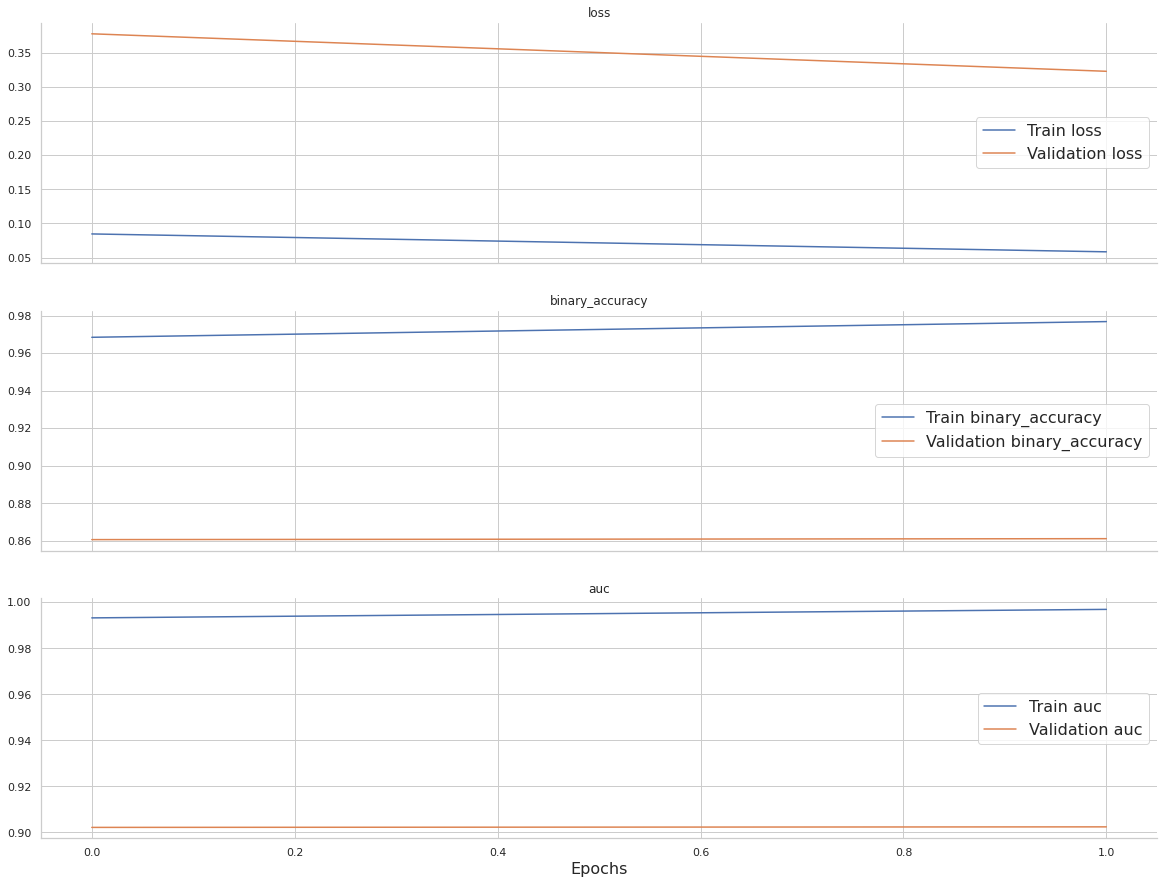

In [8]:
sns.set(style="whitegrid")
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [9]:
display(evaluate_model(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1
Metric,,,,,
ROC AUC,0.772429,0.771473,0.0009557,0.772429,0.771473
Accuracy,0.854567,0.853491,0.00107567,0.854567,0.853491
Precision,0.942118,0.937535,0.00458266,0.942118,0.937535
Recall,0.560072,0.559427,0.000645536,0.560072,0.559427
F1-score,0.702513,0.700729,0.00178414,0.702513,0.700729
Support,106888,26722,80166,106888,26722


# Confusion matrix

Fold: 1


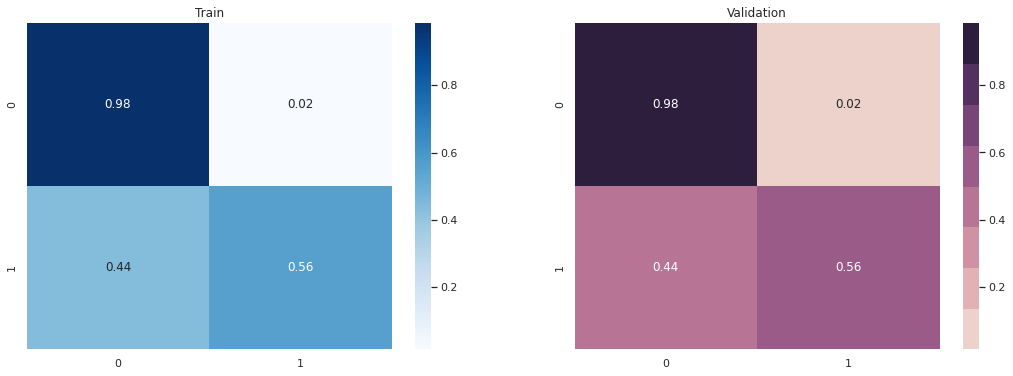

In [10]:
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    train_set = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'train']
    validation_set = k_fold[k_fold['fold_%d' % (n_fold+1)] == 'validation'] 
    plot_confusion_matrix(train_set['toxic'], train_set['pred_%d' % (n_fold+1)], 
                          validation_set['toxic'], validation_set['pred_%d' % (n_fold+1)])

# Model evaluation by language

In [11]:
display(evaluate_model_lang(valid_df, config['N_FOLDS']).style.applymap(color_map))

,Mean,Fold_1
Lang / ROC AUC,,
Overall,0.577314,0.577314
es,0.615115,0.615115
it,0.583293,0.583293
tr,0.510938,0.510938


# Visualize predictions

In [12]:
pd.set_option('max_colwidth', 120)
display(k_fold[['comment_text', 'toxic'] + [c for c in k_fold.columns if c.startswith('pred')]].head(15))

,comment_text,toxic,pred_1
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, jus...",0,0.0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0.0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and ...",0,0.0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on,...",0,0.0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0,0.0
5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0,0.0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1.0
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0,0.0
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow th...",0,0.0
9,alignment on this subject and which are contrary to those of DuLithgow,0,0.0
